In [1]:
# https://mlbootcamp.ru/article/tutorial/  Руководство для начинающих
import zmq
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO

import pandas as pd
import numpy as np
from scipy import spatial as spat
import copy
from sklearn import metrics, pipeline, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
#from datetime import datetime
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%%time
# Предварительная обработка выгруженных данных из MT5
# Загрузка истории котировок
df_instr = pd.read_csv('BR Splice_H1.csv', encoding='ansi', header=0, sep=';') #, nrows=10000)
df_instr = df_instr[:-30] # удаляем кривые значения в начале истории
# отступаем от начала и удаляем нулевые значения ZigZag вначале массива данных
z = 20
df_instr.drop(range(z), axis=0, inplace=True)
while df_instr.loc[z,'ZigZag'] == 0:
    df_instr.drop([z], axis=0, inplace=True)
    z+=1

df_instr.reset_index(drop=True, inplace=True)   

# вычисляем направления тренда ZigZag
n = df_instr.shape[0]
fix_extr = df_instr['ZigZag'].loc[0]
fix_interval = 0
for i in range(n):
    df_instr.at[i,'Interval'] = fix_interval
    fix_interval += 1
    if df_instr['ZigZag'].loc[i] != 0:
        delta = (fix_extr - df_instr['ZigZag'].loc[i])/fix_interval  
        df_instr.at[i-fix_interval:i-1, 'Trend'] = delta
        fix_extr = df_instr['ZigZag'].loc[i]
        fix_interval = 0

#Приводим значения к целому типу
df_instr['Interval'] = df_instr['Interval'].astype('int', copy=False)

#смещаем значение тренда на 1 шаг назад - прогнозная модель на 1 шаг.
df_instr['Trend'] = df_instr['Trend'].shift(1)

#классифицируем направление тренда
df_instr['VN'] = df_instr['Trend'].apply(lambda x: 1 if x>0 else -1)  # 1 - вверх, -1 - вниз

# удаляем строки с пустыми ячейками в конце массива данных
df_instr.dropna(inplace = True)

# сохраняем результат первичной обработки данных
df_instr.drop(['ZigZag'], axis=1).to_csv('BR Splice_H1_obr.csv', sep=';', header=True, index=False)

Wall time: 4.15 s


In [2]:
# функция выборки (сдвига) столбцов для анализа
def shift(Column,step,df):
    if step==0:
        df.drop([Column], axis = 1,inplace=True)
    elif step>1:
        Column0 = Column+'0'
        df.rename(columns={Column: Column0}, inplace=True)
        for i in range(1,step):
            df[Column+str(i)] = df[Column0].shift(-i)

In [4]:
# функция сравнения шаблонов с образцом
def sravn(npX, obrazec, t, w):

    if t != 5:
        x_np = RobustScaler().fit_transform(npX.reshape(-1, 1))
    
    if t == 1:
        return spat.distance.braycurtis(x_np, obrazec, w)
    if t == 2:
        return spat.distance.canberra(x_np, obrazec, w)
    if t == 3:
        return spat.distance.chebyshev(x_np, obrazec, w)
    if t == 4:
        return spat.distance.cityblock(x_np, obrazec, w)
    if t == 5:
        #return spat.distance.correlation(x_np, obrazec, w)
        return spat.distance.correlation(npX, obrazec, w)
    if t == 6:
        return spat.distance.cosine(x_np, obrazec, w)
    if t == 7:
        return spat.distance.euclidean(x_np, obrazec, w)
    if t == 8:
        return spat.distance.minkowski(x_np, obrazec, 1, w)
    if t == 9:
        return spat.distance.sqeuclidean(x_np, obrazec, w)
    raise ValueError('Undefined tip: {}'.format(tip))

#функция поиска шаблонов
def massiv_wablonov(df_instr_vhod, obrazec1, obrazec2, otst, nbar, nwabmax, tip, kol):
#def massiv_wablonov(df_instr_vhod, obrazec1, obrazec2, otst, nbar, nwabmax, tip, porog):    
    # задаем массив весовых коэффициентов - свежие значения более значимые
    weight = np.linspace(1,0,nbar)
    
    #выбираем шаблоны отступив от начала для исключения совпадения по первому столбцу данных
    res1 = df_instr_vhod[zagolovok1].iloc[nbar*2+otst:].rolling(window=nbar).apply(lambda x: sravn(x, obrazec1, tip, weight),raw=True)
    res1.dropna(inplace=True) 
    # создаем df для записи результатов - дистанций по первому столбцу      
    df_spisok_wab = pd.DataFrame(res1)
    df_spisok_wab['Nomer'] = df_spisok_wab.index -(nbar-1) # фиксируем номера шаблонов
    # выбираем nwabmax наименьших дистанций для следующего прохода по второму столбцу данных
    df_spisok = df_spisok_wab.sort_values(by =zagolovok1 ).iloc[:nwabmax].reset_index(drop=True)
    # делаем проход по второму столбцу данных на отобранных шаблонах
    df_spisok[zagolovok2] = df_spisok['Nomer'].apply(lambda x: sravn(df_instr_vhod[zagolovok2].iloc[x:x+nbar].values, obrazec2,tip,weight))
    # фиксируем итоговую дистанцию по обоим столбцам
    df_spisok['Dist'] = df_spisok[zagolovok1] +df_spisok[zagolovok2] 
    # возвращаем сортированный результат в пределах требуемого количества шаблонов
    return df_spisok.sort_values(by ='Dist').iloc[:kol].reset_index(drop=True)
        # возвращаем сортированный результат в пределах заданного порога макс дистанции
        #return df_spisok[df_spisok['Dist'] < porog].sort_values(by ='Dist').reset_index(drop=True)

In [5]:
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')
#from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier


tip_dist = 5   # тип сравнения образца и шаблона
#kol_wab = 82 # количество отбираемых шаблонов для последующего анализа
#sredn_otkl = 0.07   # средняя разница между величиной образца и шаблона
porog_otkl = 0.06    # макс разница (дистанция) между образцом и шаблоном
min_wab = 5          # мин кол-во шаблонов для классификации

df_instr_sort = df_instr_obr[['Bears','Bulls','CHO','HL','OsMA','RSI','StdDev','WPR','VN']]
#z = [3,2,0,1,0,6,5,2]

def Vibor_BestClas(z):
    min_wab = z[2] # мин кол-во шаблонов для классификации
    porog_otkl = z[3]/100 #0.07   # макс разница (дистанция) между образцом и шаблоном
    
    #df_instr_sort = df_instr_obr[['Bears','Bulls','CHO','HL','OsMA','RSI','StdDev','WPR','VN']]
    #df_instr_sort = df_instr_obr[['Bears','Bulls','WPR','VN']]
    df_instr_sort = df_instr_obr[[z[0],'WPR','VN']]
    # отбираем столбцы для анализа
    sh = z[1]
    shift(z[0],sh, df_instr_sort)
    shift('WPR',sh, df_instr_sort)
    
    if df_instr_sort.drop(['VN'],1).empty: 
        print ('пусто')
        return 0

    df_nomer_wab.dropna(axis=1,inplace=True)

    #список для результатов классификации по колонкам
    #l_score = []
    # список для проверки прогноза
    #l_progn = []
    
    df_test = pd.DataFrame(columns=['col','kol_wab','score', 'sovp'])
    
    for col in df_nomer_wab.columns: #[1000:1500]:
        # формируем массив шаблонов
        df_wab = pd.DataFrame(data = np.array(df_nomer_wab[str(int(col))]), columns =['nomer'])
        df_wab['dist'] = df_dist_wab[str(int(col))]
        # берем список номеров шаблонов для дальнейшей обработки отфильтрованный по порогу дистанции
        comp = df_wab[(df_wab['dist']<porog_otkl) & (df_wab['dist']>0.0001)]['nomer']
        
        if len(comp)>min_wab:
            #разбиваем на обучающую и тестовую выборку
            y = df_instr_sort['VN'].iloc[comp]
            X = df_instr_sort.drop(['VN'],1).iloc[comp]
            #StScal = StandardScaler()
            #X_scal = StScal.fit_transform(X)
            X_scal = X/100
            X_train, X_test, y_train, y_test = train_test_split(X_scal, y, test_size=.3, random_state=40)

            # учим классификатор
            clf = MLPClassifier(random_state=42, alpha=z[4], max_iter=z[5], hidden_layer_sizes=(z[6],z[7]))
            #clf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, random_state=42)
            #clf = AdaBoostClassifier()
            clf.fit(X_train, y_train)
            # проверяем на тестовых данных
            score0 = clf.score(X_test, y_test)
            # заполняем список по результатам классификации
            #l_score.append(score0)
            if score0 >=0.8:
            #прогнозируем тренд
                y = df_instr_sort['VN'].iloc[int(col)]
                X = df_instr_sort.drop(['VN'],1).iloc[int(col)]
                #X_scal = StScal.transform(X.values.reshape(1, -1))
                X_scal = (X/100).values.reshape(1, -1)
                y_progn = clf.predict(X_scal)
                if (y_progn == y):
                    sovp = 1
                else: 
                    sovp = 0
                #l_progn.append(sovp)

                #сохраняем результаты в 1 DataFrame
                df_test = df_test.append([{'col':col, 'kol_wab':len(comp),
                                           'score':score0, 'sovp':sovp
                                           }],ignore_index=True)

    #score_m =round(np.mean(l_score),3)
    #progn_m = round(np.mean(l_progn),3) 
    #print('progn=',progn_m,' sc_m=',score_m,' Bears=',Bears,' Bulls=',Bulls,' CHO=',CHO,' HL=',HL,' OsMA=',OsMA,' RSI=',RSI,' StdDev=',StdDev,' WPR=',WPR)
    print('progn=',round(df_test['sovp'].mean(),3),' sc_m=',round(df_test['score'].mean(),3),' strok=',df_test.shape[0],'min_wab= ',z[2], 'porog_otkl= ',z[3],' alpha= ',z[4],' max_iter=',z[5],' lay1=',z[6],' lay2=',z[7])
    return(df_test)

<IPython.core.display.Javascript object>


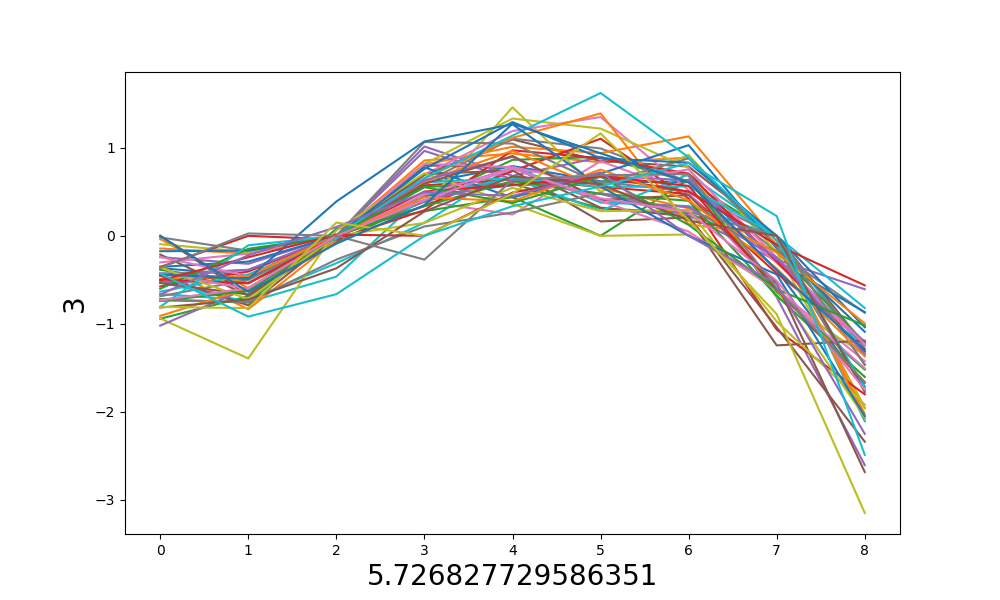

In [5]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure(figsize=(10,6))
def animate(i):
    plt.clf()
    otstup = i
    
    #формируем массивы образцов
    np_obrazec1 = RobustScaler().fit_transform(df_instr_obr[zagolovok1].iloc[otstup:numberbar+otstup].values.reshape(-1, 1))
    np_obrazec2 = RobustScaler().fit_transform(df_instr_obr[zagolovok2].iloc[otstup:numberbar+otstup].values.reshape(-1, 1))
    
    #выбираем шаблоны по сумме двух столбцов
    df_spisok_wab = massiv_wablonov(df_instr_obr, np_obrazec1, np_obrazec2, otstup, numberbar, max_kol_wab, tip_dist, kol_wab)
    plt.xlabel(df_spisok_wab.iloc[-1,3],fontsize=20)
    plt.ylabel(otstup,fontsize=20)
    
    np_plot = RobustScaler().fit_transform(df_instr_obr['Sredn'].iloc[otstup:numberbar+otstup].values.reshape(-1, 1)).reshape(1,-1)
    for i in df_spisok_wab['Nomer']:
        np_frame = RobustScaler().fit_transform(df_instr_obr['Sredn'].iloc[i:i+numberbar].values.reshape(-1, 1)).reshape(1,-1)
        np_plot = np.append(np_plot,np_frame,axis=0)
    
    plt.plot(np_plot.T)
ani = animation.FuncAnimation(fig, animate, frames=range(10,-1,-1), repeat=True, interval=50)

In [4]:
context = zmq.Context()
socket = context.socket(zmq.REP)

socket.bind("tcp://127.0.0.1:5555")
message='start'

In [ ]:
while (message!='stopp'):
    #получаем количество бар образца numberbar и количество шаблонов numberwabmax
    #print("Ждем настройки") 
    message = socket.recv().decode("utf-8")
    
    if message == 'stopp': # прерываем цикл 
        break

    numberbar,sredn_otkl = (x for x in message.split(";"))
    numberbar = int(numberbar)
    sredn_otkl = float(sredn_otkl)
    #print('numberbar=', numberbar)
    #print('sredn_otkl=', sredn_otkl)
    
    #numberbar = 9   # количество бар образца и шаблонов
    tip_dist = 4   # тип сравнения образца и шаблона функия kor
    max_kol_wab = 10000   # максимальная выборка шаблонов по первому столбцу данных
    #sredn_otkl = 0.7   # средняя разница между величиной образца и шаблона
    porog_wab  = sredn_otkl*numberbar   # предельная разница между образцом и шаблоном
    otstup = 0 # отступ от начала массива данных для тестирования
    min_wabl = 4 # минимальное количество шаблонов для прогноза
    goriz_progn = 1 #горизонт прогноза

    
    # отвечаем требуемое количество бар
    res = (str(numberbar))
    socket.send(res.encode('utf-8'))
    #print("Нужное количество бар отправлено, ждем данные")

    message = socket.recv().decode("utf-8")
    #print("Полученны данные")
    #print(message)

    TESTDATA = StringIO(message)
    df_message = pd.read_csv(TESTDATA, sep=";")
    
    
    df_message['sredn_HL'] = (df_message['High']+df_message['Low'])/2
    df_message['HL'] = df_message['High']-df_message['Low']
    
    #print(df_message)
    # формируем образцы данных по столбцам
    np_obrazec1 = MinMaxScaler (df_message[zagolovok1].values)
    np_obrazec2 = MinMaxScaler (df_message[zagolovok2].values)
    #print('np_obrazec1', np_obrazec1)
    #print('np_obrazec2', np_obrazec2)
    
    #выбираем шаблоны по сумме двух столбцов
    df_spisok_wab = massiv_wablonov(df_instr, np_obrazec1, np_obrazec2, otstup, numberbar, max_kol_wab, tip_dist, porog_wab)
        
    #фиксируем количество шаблонов
    Nwabl = df_spisok_wab.shape[0]
    #print(df_spisok_wab)            
    
    if Nwabl>min_wabl:
            
        df_spisok_wab['Trend'] = df_spisok_wab['Nomer'].apply(lambda x: df_instr['Trend'].iloc[x-goriz_progn])
        df_spisok_wab['VN'] = df_spisok_wab['Trend'].apply(lambda x: 1 if x>0 else -1)
            
        #делаем прогноз изменения цены по количеству
        VN = df_spisok_wab['VN'].mean()
        command = VN
    else: command = 999999 # сигнал не определен

    # отвечаем результат прогноза
    res = (str(command))
    socket.send(res.encode('utf-8'))
    #print("Команда отправлена")

C:\Users\A\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


In [11]:
socket.close()